<a href="https://colab.research.google.com/github/Hiranmai-T/EVA/blob/master/S6/EVA4_Assignment6_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.pool2 = nn.MaxPool2d(2, 2)
        self.convblock9 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        # self.convblock7 = nn.Sequential(
        #     nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),            
        #     nn.BatchNorm2d(16),
        #     nn.Dropout(dropout_value)
        # ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            #nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        #x = self.pool2(x)
        #x = self.convblock9(x)
        x = self.convblock6(x)
        #x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [3]:

!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             256
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 10, 10, 10]             720
             ReLU-12           [-1, 10, 10, 10]               0
      BatchNorm2d-13           [-1, 10, 10, 10]              20
          Dropout-14           [-1, 10,

In [0]:
test_loss_l1=[]
test_acc_l1=[]
test_loss_l2=[]
test_acc_l2=[]
test_loss_both=[]
test_acc_both=[]

In [0]:


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
misclassified=[]
lambda1=0.0001
lambda2 = 0.01
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    #loss += lambda1*torch.norm(model.parameters(),1)
    #model_params = torch.cat([x.view(-1) for x in model.parameters()])
    #loss += lambda1*torch.norm(model_params,1)
    regularization_loss = 0
    for param in model.parameters():
      regularization_loss += torch.sum(torch.abs(param))
    loss += lambda1*regularization_loss
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            temp = pred.eq(target.view_as(pred)).sum().item()
            temp1 = target.view_as(pred)
            if(len(misclassified)<25):
              for i in range(len(temp1)):
                if(temp1[i]!=pred[i]):
                  misclassified.append([data[i],temp1[i],pred[i]])
                if(len(misclassified)==25):
                  break
            correct += temp


    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [7]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1)
#scheduler = MultiStepLR(optimizer, [], gamma=0.1, last_epoch=-1)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
#                                                      patience=3, 
#                                                      verbose=0, 
#                                                      factor=0.5, 
#                                                      min_lr=0.00001)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.23862013220787048 Batch_id=468 Accuracy=85.41: 100%|██████████| 469/469 [00:13<00:00, 35.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0993, Accuracy: 9725/10000 (97.25%)

EPOCH: 1


Loss=0.14542073011398315 Batch_id=468 Accuracy=96.92: 100%|██████████| 469/469 [00:13<00:00, 34.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0595, Accuracy: 9831/10000 (98.31%)

EPOCH: 2


Loss=0.11343766748905182 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:14<00:00, 33.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Accuracy: 9893/10000 (98.93%)

EPOCH: 3


Loss=0.1202680766582489 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:14<00:00, 33.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9892/10000 (98.92%)

EPOCH: 4


Loss=0.14209821820259094 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:14<00:00, 32.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Accuracy: 9890/10000 (98.90%)

EPOCH: 5


Loss=0.18432579934597015 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:13<00:00, 33.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0452, Accuracy: 9859/10000 (98.59%)

EPOCH: 6


Loss=0.09830182790756226 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:13<00:00, 33.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9902/10000 (99.02%)

EPOCH: 7


Loss=0.15373603999614716 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:14<00:00, 33.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9914/10000 (99.14%)

EPOCH: 8


Loss=0.14039689302444458 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:14<00:00, 33.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9911/10000 (99.11%)

EPOCH: 9


Loss=0.09006301313638687 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:13<00:00, 34.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Accuracy: 9879/10000 (98.79%)

EPOCH: 10


Loss=0.06839580088853836 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:14<00:00, 33.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9924/10000 (99.24%)

EPOCH: 11


Loss=0.10711323469877243 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:13<00:00, 34.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9893/10000 (98.93%)

EPOCH: 12


Loss=0.09810306131839752 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:13<00:00, 33.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9919/10000 (99.19%)

EPOCH: 13


Loss=0.12392181158065796 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:13<00:00, 35.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9894/10000 (98.94%)

EPOCH: 14


Loss=0.07366500049829483 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:14<00:00, 31.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9927/10000 (99.27%)

EPOCH: 15


Loss=0.07844950258731842 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:13<00:00, 33.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9933/10000 (99.33%)

EPOCH: 16


Loss=0.06352442502975464 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:13<00:00, 33.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9917/10000 (99.17%)

EPOCH: 17


Loss=0.17222295701503754 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:13<00:00, 34.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9913/10000 (99.13%)

EPOCH: 18


Loss=0.10027782618999481 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:14<00:00, 32.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9926/10000 (99.26%)

EPOCH: 19


Loss=0.07852707803249359 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:14<00:00, 34.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9924/10000 (99.24%)

EPOCH: 20


Loss=0.09043243527412415 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:13<00:00, 33.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9921/10000 (99.21%)

EPOCH: 21


Loss=0.07667013257741928 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:13<00:00, 33.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9932/10000 (99.32%)

EPOCH: 22


Loss=0.06245844066143036 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:14<00:00, 33.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9912/10000 (99.12%)

EPOCH: 23


Loss=0.07502572238445282 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:13<00:00, 33.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9939/10000 (99.39%)

EPOCH: 24


Loss=0.0634954497218132 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:13<00:00, 35.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9916/10000 (99.16%)

EPOCH: 25


Loss=0.06158781796693802 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:13<00:00, 33.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9927/10000 (99.27%)

EPOCH: 26


Loss=0.0758020430803299 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:14<00:00, 33.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9934/10000 (99.34%)

EPOCH: 27


Loss=0.06378188729286194 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:14<00:00, 32.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9921/10000 (99.21%)

EPOCH: 28


Loss=0.06932629644870758 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:13<00:00, 34.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9929/10000 (99.29%)

EPOCH: 29


Loss=0.05971154943108559 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:13<00:00, 33.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9932/10000 (99.32%)

EPOCH: 30


Loss=0.06084509566426277 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:14<00:00, 32.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9920/10000 (99.20%)

EPOCH: 31


Loss=0.08142135292291641 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:13<00:00, 33.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9925/10000 (99.25%)

EPOCH: 32


Loss=0.10845108330249786 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:13<00:00, 33.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9930/10000 (99.30%)

EPOCH: 33


Loss=0.07245150953531265 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:13<00:00, 33.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9927/10000 (99.27%)

EPOCH: 34


Loss=0.2550996243953705 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:14<00:00, 33.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9936/10000 (99.36%)

EPOCH: 35


Loss=0.06014726310968399 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:13<00:00, 33.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9929/10000 (99.29%)

EPOCH: 36


Loss=0.11663660407066345 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:13<00:00, 34.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9921/10000 (99.21%)

EPOCH: 37


Loss=0.10740296542644501 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:13<00:00, 33.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9926/10000 (99.26%)

EPOCH: 38


Loss=0.06940735131502151 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:14<00:00, 33.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9930/10000 (99.30%)

EPOCH: 39


Loss=0.054129425436258316 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:13<00:00, 33.84it/s]



Test set: Average loss: 0.0273, Accuracy: 9915/10000 (99.15%)



Text(0.5, 1.0, 'Test Accuracy')

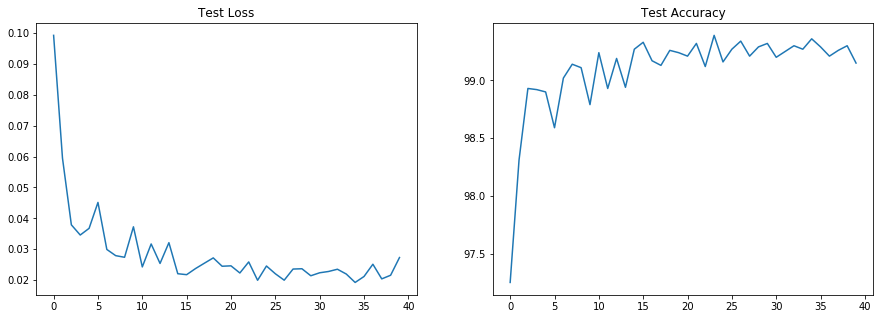

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(15,5))
# axs[0, 0].plot(train_losses)
# axs[0, 0].set_title("Training Loss")
# axs[1, 0].plot(train_acc[4000:])
# axs[1, 0].set_title("Training Accuracy")
axs[0].plot(test_losses)
axs[0].set_title("Test Loss")
axs[1].plot(test_acc)
axs[1].set_title("Test Accuracy")

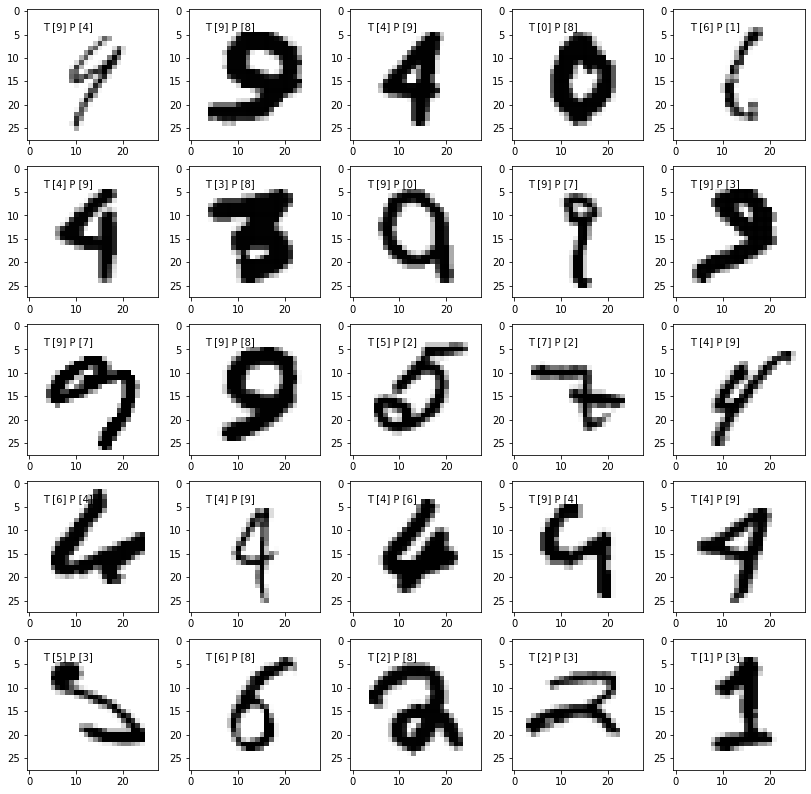

In [9]:
fig, axs = plt.subplots(5,5,figsize=(14,14))
index=0
for i in range(5):
  for j in range(5):
    data,t,p = misclassified[index]
    axs[i,j].imshow(data.cpu().numpy().squeeze(), cmap='gray_r')
    #axs[i,j].set_title(str(t.cpu().numpy())+" "+str(p.cpu().numpy()))
    axs[i,j].annotate("T "+str(t.cpu().numpy())+" P "+str(p.cpu().numpy()),(3,4))
    index+=1;
